In [1]:
import os 

from AEMG.data_utils import DynamicsDataset
from AEMG.systems.utils import get_system

import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

import torch 
from torch.utils.data import DataLoader
from AEMG.models import *

from tqdm.notebook import tqdm 
import pickle

In [2]:
system = get_system("pendulum")
config_fname = "config/pendulum_none_1K.txt"

with open(config_fname, 'r') as f:
    config = eval(f.read())

dataset = DynamicsDataset(config)

100%|██████████| 1024/1024 [00:01<00:00, 828.68it/s]


In [ ]:
# Split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)


In [ ]:
encoder  = Encoder(config["high_dims"],config["low_dims"])
dynamics = LatentDynamics(config["low_dims"])
decoder  = Decoder(config["low_dims"],config["high_dims"])

In [ ]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(set(list(encoder.parameters()) + list(dynamics.parameters()) + list(decoder.parameters())), 
    lr=config["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=5, verbose=True)

In [ ]:
train_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_total': []}
test_losses = {'loss_ae1': [], 'loss_ae2': [], 'loss_dyn': [], 'loss_total': []}

for epoch in tqdm(range(config["epochs"])):
    loss_ae1_train = 0
    loss_ae2_train = 0
    loss_dyn_train = 0

    current_train_loss = 0
    epoch_train_loss = 0

    warmup = 1 if epoch <= config["warmup"] else 0

    encoder.train()
    dynamics.train()
    decoder.train()

    counter = 0
    for i, (x_t, x_tau) in enumerate(train_loader,0):
        optimizer.zero_grad()

        # Forward pass
        z_t = encoder(x_t)
        x_t_pred = decoder(z_t)

        z_tau_pred = dynamics(z_t)
        z_tau = encoder(x_tau)
        x_tau_pred = decoder(z_tau_pred)

        # Compute losses
        loss_ae1 = criterion(x_t, x_t_pred)
        loss_ae2 = criterion(x_tau, x_tau_pred)
        loss_dyn = criterion(z_tau, z_tau_pred)

        loss_total = loss_ae1 + loss_ae2 + warmup * loss_dyn

        # Backward pass
        loss_total.backward()
        optimizer.step()

        current_train_loss += loss_total.item()
        epoch_train_loss += loss_total.item()

        loss_ae1_train += loss_ae1.item()
        loss_ae2_train += loss_ae2.item()
        loss_dyn_train += loss_dyn.item() * warmup
        counter += 1

        if (i+1) % 100 == 0:
            print("Epoch: {}, Iteration: {}, Loss: {}".format(epoch, i+1, current_train_loss))
            current_train_loss = 0
        
    train_losses['loss_ae1'].append(loss_ae1_train / counter)
    train_losses['loss_ae2'].append(loss_ae2_train / counter)
    train_losses['loss_dyn'].append(loss_dyn_train / counter)
    train_losses['loss_total'].append(epoch_train_loss / counter)

    with torch.no_grad():
        loss_ae1_test = 0
        loss_ae2_test = 0
        loss_dyn_test = 0
        epoch_test_loss = 0

        encoder.eval()
        dynamics.eval()
        decoder.eval()

        counter = 0
        for i, (x_t, x_tau) in enumerate(test_loader,0):
            # Forward pass
            z_t = encoder(x_t)
            x_t_pred = decoder(z_t)

            z_tau_pred = dynamics(z_t)
            z_tau = encoder(x_tau)
            x_tau_pred = decoder(z_tau_pred)

            # Compute losses
            loss_ae1 = criterion(x_t, x_t_pred)
            loss_ae2 = criterion(x_tau, x_tau_pred)
            loss_dyn = criterion(z_tau, z_tau_pred)

            loss_total = loss_ae1 + loss_ae2 + warmup * loss_dyn

            epoch_test_loss += loss_total.item()

            loss_ae1_test += loss_ae1.item()
            loss_ae2_test += loss_ae2.item()
            loss_dyn_test += loss_dyn.item() * warmup
            counter += 1

        test_losses['loss_ae1'].append(loss_ae1_test / counter)
        test_losses['loss_ae2'].append(loss_ae2_test / counter)
        test_losses['loss_dyn'].append(loss_dyn_test / counter)
        test_losses['loss_total'].append(epoch_test_loss / counter)

        if epoch >= config["warmup"]:
            scheduler.step(epoch_test_loss / counter)
        
    print("Epoch: {}, Train Loss: {}, Test Loss: {}".format(epoch, epoch_train_loss / counter, epoch_test_loss / counter))

In [ ]:
# Save the models
torch.save(encoder, os.path.join(config["model_dir"], "encoder.pt"))
torch.save(dynamics, os.path.join(config["model_dir"], "dynamics.pt"))
torch.save(decoder, os.path.join(config["model_dir"], "decoder.pt"))

In [ ]:
# if log_dir doesn't exist, create it
if not os.path.exists(config["log_dir"]):
    os.makedirs(config["log_dir"])

# Save the losses as a pickle file
with open(os.path.join(config["log_dir"], "losses.pkl"), "wb") as f:
    pickle.dump({"train_losses": train_losses, "test_losses": test_losses}, f)

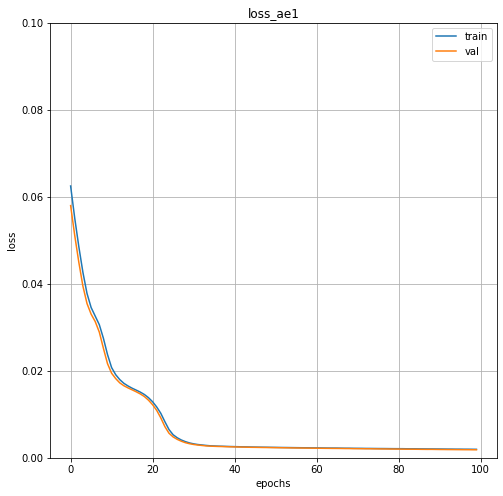

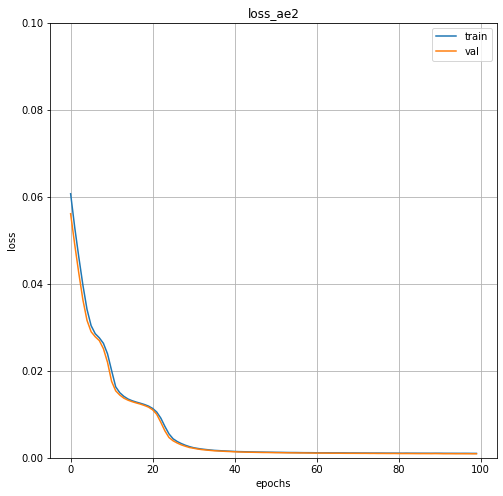

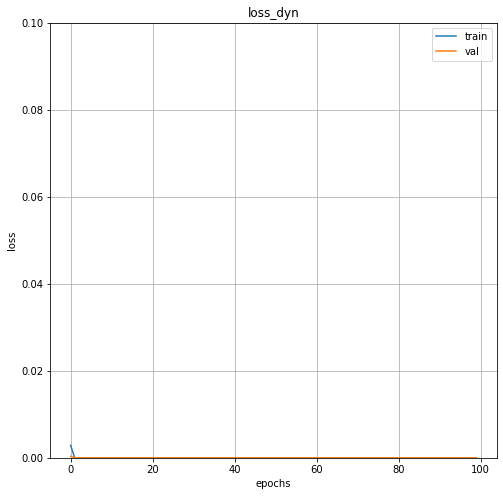

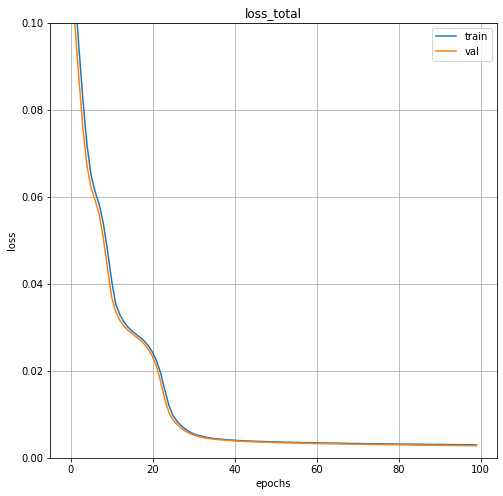

In [3]:
from AEMG.plot_losses import plot_losses

plot_losses(config)